""" 
Makes nice planview plots from .obb files.

...........

Uses .csv files that are converted from .obb files by obbprint with script: planview_NetJet.sh

...........


Know these things about your code:
----------------------------------
1. How many km out from the origin the PE (Peregrine) was run
2. Your GPS point of origin

Original version of this code that lays out all types of mapping packages tried is called:
-----------------------------------
NotJet_Planview_old
and is in this same repository


"""

In [27]:
%matplotlib inline

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.cm as cm
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy import config
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from palettable import colorbrewer

import os

# Import the planview csv file 

""" 
For the Piles project, that is in ~/models/projects/Env_sensitivity/Planview_Cartopy/

w/ filename

RIsland_planview_SEL.csv
"""


In [3]:
SEL_RI = pd.read_csv('RIsland_planview_SEL.csv', delimiter = ',',na_values=" -inf",header=None)

#If needed, get rid of wierd "-inf;" final column from obbprint

SEL_RI = SEL_RI.iloc[:,0:359] 

In [4]:
# Find max value in this entire excel sheet to make the upper limit of the plan view later

rowmax_RI = SEL_RI.max(0)
matrixmax_RI = rowmax_RI.max()
matrixmax_RI

180.2102

In [5]:
# Find min value and make sure it doesn't go below zero for plan view later
# The zero lower limit threshold can be changed to whatever lower limit is desired

rowmin_RI = SEL_RI.min(1)
matrixmin_RI = rowmin_RI.min()

if matrixmin_RI < 0: # Change to desired lower limit 
    matrixmin_RI = 0
else:
    matrixmin_RI = matrixmin_RI
    
matrixmin_RI

0

# Figure out how many degrees each .csv box represents in your matrix

"""

In this case: 
-------------
The peregrine run went out to 60 km  
N to S or E to W span is therefore 120 km 
So 120e3 meters / 360 columns (longitudes), means each column is 333 m away from the adjacent ones. 
Similarly, 120e3 meters / 359 rows (latitudes), means each row is 335 m away from the adjacent ones.

Example calculation w/ 111120:
------------------------------
For -115 + (2000/111120)" ...

-115 is the central latitude 
2000 is the number of meters for each grid spacing (between each column / row)
111120 is the number of meters in one degree of lat or lon 
    (adjust for closer to equator or poles if needed)

"""

In [6]:
359*333 
# The number of meters from North to South of our goal map
# 359 because there were 359 rows in the excel sheet of data
# Put this result in the output in two steps for finding out the Southern limit of the map

119547

In [7]:
359*335 
# The number of meters from West to East of our goal map
# Put this result in the output in two steps for finding out the Western limit of the map

120265

# Make a lat/lon array centered at: 
 	41.4215333°, -069.7055167° (RI) --> Example site for this notebook
 	36.8962867°, -075.4916333° (VA)

In [8]:
RIlon = -71.22270
RIlat = 41.08776

In [9]:
# Farthest West side of the map will be
Wgap = 119547/2/111120 #degrees away from center

# Farthest South limit of the map will be
Sgap = 120265/2/111120 #degrees away from center

In [11]:
RIw = RIlon - Wgap # Western border of the grid at RIsland

RIe = RIlon + Wgap # Eastern border of the grid at RIsland

RIs = RIlat - Sgap # Southern border of the grid at RIsland

RIn = RIlat + Sgap # Northern border of the grid at RIsland

# Careful about + and - here if you are not in the NW hemisphere

In [12]:
# Create a full matrix for latitude and a full matrix for longitude now using two sides of the limits above

lonRI = np.arange(0,119547,333)/111120 + RIw
# This is the: (latitude from 0 to 120 km in 359 steps)/number of degrees in each meter + starting point on the map (the bottom left corner)

latRI = np.arange(0,120265,335)/111120 + RIs

latRI1,lonRI1 = np.meshgrid(latRI,lonRI)

In [13]:
# Check that one of the matrices is the expected dims (359x359 in this case)
np.shape(latRI1) 

(359, 359)

# Decide which SEL thresholds LEVELS to use in the next part of code:

Low Freq MarMams:
-----------------
PTS & TTS in SELw,24hr = 168 & 183; in SEL3500 = 147.6 & 132.6

Mid Freq MarMams:
------------------
PTS & TTS in SELw,24hr = 170 & 185; in SEL3500 = 149.6 & 134.6

High Freq MarMams:
-------------------
PTS & TTS in SELw,24hr = 140 & 155; in SEL3500 = 119.6 & 104.6

Phocid:
--------------------
PTS & TTS in SELw,24hr = 170 & 185; in SEL3500 = 149.6 & 134.6

In [16]:
PTS = 147.6
TTS = 132.6

# MAPPING OPTION 1 OF 2

In [20]:
# Use cartopy option from Filipe Fernandez (@osefpaf in Slack)
# https://nbviewer.jupyter.org/github/ocefpaf/PIRATA/blob/master/CTD-PIRATA-Processing.ipynb

# Define land and ocean colormaps --> See Filipe's jupyter notebook for colorbrewer numberical settings 
                                    # (it's not a simple 1 though 10 integer continuum)
    
LAND = colorbrewer.get_map("Greens", "sequential", 9)
OCEAN = colorbrewer.get_map("Blues", "sequential", 9, reverse=True)
LAND_OCEAN = np.array(OCEAN.mpl_colors + LAND.mpl_colors)

In [21]:
# Set zoom level for the tiles later
z = 10 

In [22]:
# Define how to make a map the way Filipe does it (hence the _F...there are many make_map def's online)

# For different projection options, see: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html
    # figsize is the actual size of the figure on the screen of your computer

def make_map_F(extent, figsize=(12, 12), projection=ccrs.PlateCarree()): 
    fig, ax = plt.subplots(
        figsize=figsize, subplot_kw={"projection": projection}
    )
    ax.set_extent(extent)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.ylines = gl.xlines = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.coastlines(resolution="50m")
    return fig, ax

In [23]:
# Define how to make topography relief with etopo data
    # Basemap in Matplotlib has this, too, but cartopy is taking over in pupolarity and usability

def add_etopo2(extent, ax, levels=None):
    import iris

    url = (
        "http://gamone.whoi.edu/thredds/dodsC/usgs/data0/bathy/ETOPO2v2c_f4.nc"
        # Other options found online that I couldn't get going very well
        #f"https://maps.heigit.org/openmapsurfer/tiles/roads/webmercator/{z}/{RIlon}/{RIlat}.png"
        #f"https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{RIlon}/{RIlat}" #this needs ESRI security token to access
    )
    cube = iris.load_cube(url)
    lon = iris.Constraint(x=lambda cell: extent[0] <= cell <= extent[1])
    lat = iris.Constraint(y=lambda cell: extent[2] <= cell <= extent[3])
    cube = cube.extract(lon & lat)
    lons = cube.coord("x").points
    lats = cube.coord("y").points
    if not levels:
        levels = sorted(
            set(
                np.r_[
                    np.linspace(cube.data.min(), -500, 2),  # bathy - makes blues bluer closer 2nd number is to 0
                    [-400, -145, -10],  # coast
                    np.linspace(100, cube.data.max(), 10),  # topo - 2nd number makes the land more bold
                ].astype(int)
            )
        )

    ax.contourf(
        lons,
        lats,
        cube.data,
        levels=levels,
        colors=LAND_OCEAN,
        zorder=0,
        alpha=0.65,
    )

In [24]:
# Define the lat / lon that you want for the map borders
extent = [-72,-70,40,42]

In [29]:
# Define the planview threshold array with upper and lower and other limits you want
    # When making the actual map, you need one fewer colors in the ax.contourf function than are in this array
levels = [matrixmin_RI,104.6,TTS,PTS,200]

# Make the actual map finally :)

Text(0.5, 1.0, 'Low Frequency Marine Mammals Planview for SEL 3500 Thresholds')

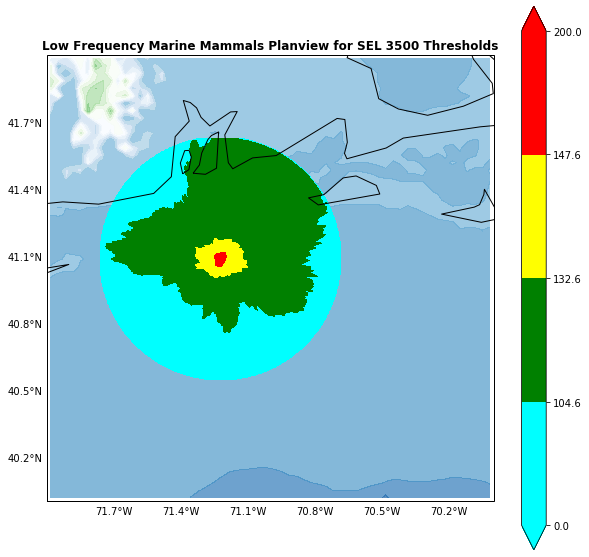

In [30]:
# The background map
fig, ax = make_map_F(extent,projection=ccrs.PlateCarree(), figsize=(10, 10))

# The topography relief
add_etopo2(extent, ax, levels=None)
 
# Add contours of planview to the background and topo maps
    # Colors can be defined here
RIsland = ax.contourf(lonRI1, latRI1, SEL_RI, levels, colors=('cyan','g','yellow','red'), 
                      transform=ccrs.PlateCarree(), extend='both')

# Add colorbar
fig.colorbar(RIsland)

# Add title
ax.set_title('Low Frequency Marine Mammals Planview for SEL 3500 Thresholds',fontsize=12,ha='center', fontweight='bold')


# MAPPING OPTION 2 OF 2

Preferred map for better background mapping - more similar to Google Maps style

NOTE:
-------
This way is harder because the coordinates don't line up magically!
You have to download a nice GEBCO map image using the N/S/E/W limits set up above 
and have it downloaded as a jpg in the repository.

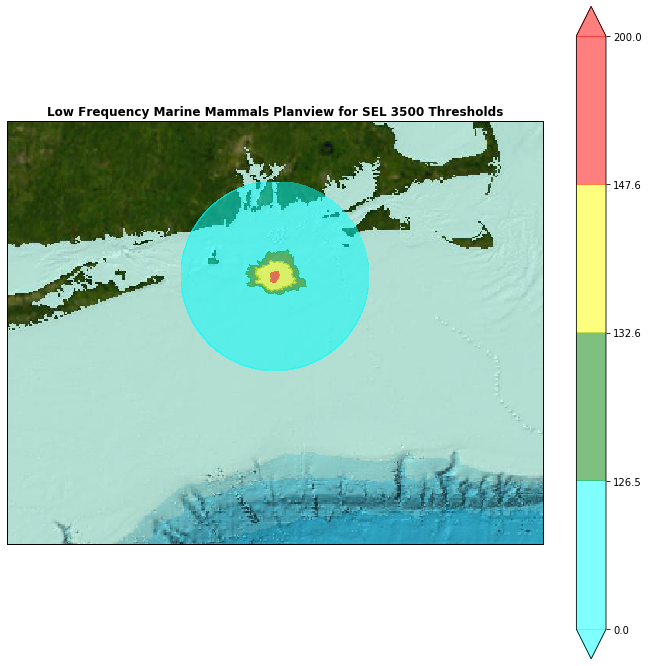

In [32]:
# From: https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/advanced_plotting.html

# Using GEBCO downloaded image named RI.jpg in working directory:
# https://www.gebco.net/data_and_products/gebco_web_services/web_map_service/mapserv?request=getmap&service=wms&BBOX=39,-73,42,-69&crs=EPSG:4326&format=image/jpeg&layers=gebco_latest&width=900&height=600&version=1.3.0
# You will need to play with the BBOX numbers (lats and lons) in the url to get the image desired

# Initiate the figure
fig = plt.figure(figsize=(12, 12))

# Import the GEBCO image
fname = 'RI.jpg' # Must match name of corresponding jpg image for this run
img_extent = (-73, -69, 39, 42) # Get these numbers from the url of the image you downloaded in the "BBOX=" part (see above for example)
img = plt.imread(fname)

# Plot background map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree())

# Plot planview contours
levels = [matrixmin_RI,126.5,TTS,PTS,200] #126.5 picked because it is the lowest instrument noise floor in Martin et al 2019
ax.set_extent([RIw-1,RIe+1,RIs-1,RIn+0.35]) # Sets bounding box of lats and lons
RIsland = ax.contourf(lonRI1, latRI1, SEL_RI, levels, colors=('cyan','g','yellow','red'), alpha=0.5,
                      transform=ccrs.PlateCarree(), extend='both') # Need one fewer color than size(levels); alpha is transparency between 0 and 1

# Add colorbar
fig.colorbar(RIsland)

# Add contour labels if want 
#ax.clabel(RIsland, fmt='%2.1f', colors='w', fontsize=14) 

# Set title
ax.set_title('Low Frequency Marine Mammals Planview for SEL 3500 Thresholds',fontsize=12,ha='center', fontweight='bold')

# Save figure
plt.savefig('RIsland_SEL_planview.png')